Name :- Pratiksha Potdar
Roll no. :- A1 30

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving student-mat.csv to student-mat (1).csv


In [ ]:
import pandas as pd

# Load dataset (note: use semicolon separator)
df = pd.read_csv("student-mat.csv", sep=';')

print("Shape of dataset:", df.shape)
print(df.head())


Shape of dataset: (395, 33)
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


In [ ]:
df = pd.read_csv("student-mat.csv", sep=';')


In [ ]:
df['pass'] = (df['G3'] >= 10).astype(int)

In [ ]:
data = df[['age', 'studytime', 'failures', 'internet', 'sex', 'pass']]

In [ ]:
data = pd.get_dummies(data, drop_first=True)

In [ ]:
print("Processed columns:", data.columns.values)

Processed columns: ['age' 'studytime' 'failures' 'pass' 'internet_yes' 'sex_M']


In [ ]:
X = data.drop('pass', axis=1)
y = data['pass']


In [ ]:
sensitive_feature = X['sex_M']

In [ ]:
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
metric_frame = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sf_test
)


In [ ]:
print("\nSelection Rates by Gender (Baseline):\n", metric_frame.by_group)


Selection Rates by Gender (Baseline):
 sex_M
False    0.862069
True     0.885246
Name: selection_rate, dtype: float64


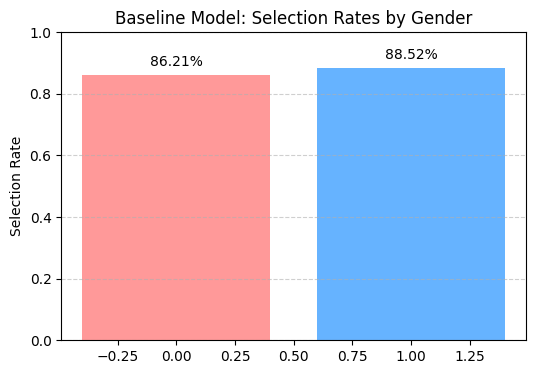

In [ ]:
selection_rates = metric_frame.by_group.to_dict()
df_vis = pd.DataFrame(list(selection_rates.items()), columns=["Gender (Male=1)", "Selection Rate"])

plt.figure(figsize=(6,4))
bars = plt.bar(df_vis["Gender (Male=1)"], df_vis["Selection Rate"], color=["#ff9999", "#66b3ff"])
plt.title("Baseline Model: Selection Rates by Gender")
plt.ylabel("Selection Rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2%}", ha='center', va='bottom')
plt.show()

In [ ]:
fair_model = ExponentiatedGradient(
    LogisticRegression(max_iter=1000),
    constraints=DemographicParity(),
    eps=0.01
)

fair_model.fit(X_train, y_train, sensitive_features=sf_train)
y_pred_fair = fair_model.predict(X_test)

In [ ]:
metric_frame_fair = MetricFrame(
    metrics={"Selection Rate": selection_rate, "Accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sf_test
)

print("\nFair Model Metrics by Gender:\n", metric_frame_fair.by_group)
print("\nOverall Accuracy (Fair Model):", accuracy_score(y_test, y_pred_fair))



Fair Model Metrics by Gender:
        Selection Rate  Accuracy
sex_M                          
False        0.896552  0.603448
True         0.852459  0.770492

Overall Accuracy (Fair Model): 0.6890756302521008


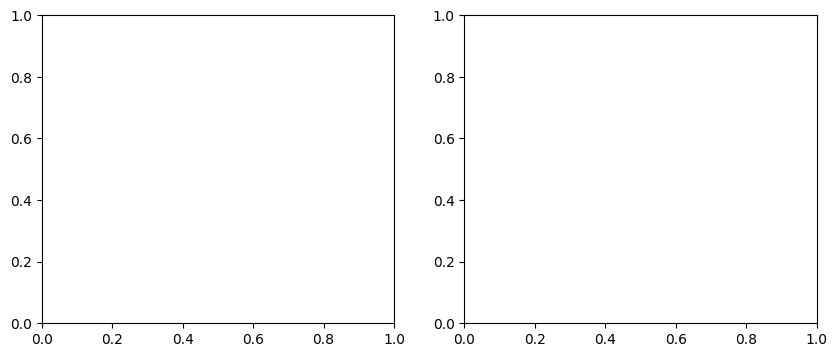

In [ ]:
selection_rates_fair = metric_frame_fair.by_group["Selection Rate"].to_dict()

fig, ax = plt.subplots(1, 2, figsize=(10,4))


In [ ]:
ax[0].bar(df_vis["Gender (Male=1)"], df_vis["Selection Rate"], color=["#ff9999", "#66b3ff"])
ax[0].set_title("Baseline Selection Rates")
ax[0].set_ylabel("Selection Rate")
ax[0].set_ylim(0, 1)

(0.0, 1.0)

In [ ]:
df_vis_fair = pd.DataFrame(list(selection_rates_fair.items()), columns=["Gender (Male=1)", "Selection Rate"])
ax[1].bar(df_vis_fair["Gender (Male=1)"], df_vis_fair["Selection Rate"], color=["#ff9999", "#66b3ff"])
ax[1].set_title("Fair Model Selection Rates")
ax[1].set_ylim(0, 1)

plt.show()